In [7]:
import numpy as np
import Levenshtein, ast, dataIO
from sklearn import cross_validation, linear_model, preprocessing, svm
from sklearn.grid_search import GridSearchCV
reload(dataIO)

def error_rate(a, b):
    msd = Levenshtein.distance(a,b)
    
    return 100.0*msd/max(len(a), len(b))

def learn_offset(points, targets):
    regr = linear_model.LinearRegression()
    regr.fit(points, targets)
    
    return regr


postures = {"left_hand":["4", "8", "11"], "right_hand":["1", "7", "10"], 
            "index_finger":["3", "5", "12"], "two_hand":["2", "6", "9"]}
                
userId = 4

keys = postures.keys()
locations = []
bod = []
targets_x = []
targets_y = []
y = []
touch_centers = []

posture = 0
for key in keys:
    filenos = postures[key]
    if key == "two_hand":
        a, b, c, d, e, f = dataIO.process_twohand(userId, posture)
        posture += 2
    else:
        a, b, c, d, e, f = dataIO.process_posture(userId, filenos, posture)
        posture += 1

    locations += a
    bod += b
    targets_x += c 
    targets_y += d 
    y += e
    touch_centers += f

locations = np.array(locations)
bod = np.array(bod)
targets_x = np.array(targets_x)
targets_y = np.array(targets_y)
y = np.array(y)
touch_centers = np.array(touch_centers)

scaler = preprocessing.StandardScaler().fit(bod)  
bod_scaled = scaler.transform(bod)

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1, 0.1 ,1e-2, 1e-3, 1e-4],
                     'C': [0.001, 0.01, 0.1 ,1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1 ,1, 10, 100, 1000]}]

clf = GridSearchCV(svm.SVC(C=1, cache_size=500), tuned_parameters)
#clf = svm.SVC(C=100, kernel='rbf', gamma=0.01, cache_size=500)
clf.fit(bod_scaled, y)

regr_x = [] 
regr_y = []

for i in range(0,5):
    index = np.where(y==i)[0]
    regr_x.append(learn_offset(locations[index], targets_x[index]))
    regr_y.append(learn_offset(locations[index], targets_y[index]))

with open("/home/dimitar/Desktop/Python/Level5Project/Loggingapp/dataset.txt") as f:
    pool = f.read().splitlines()

req_sentences = []
typed_sentences = []
pred_sentences = []

for i in range(13, 25):
    column_index = 0
    if i in [15, 17, 21]:
        column_index = 1

    with open("/home/dimitar/Desktop/Python/experiment/results/"
               +str(userId)+"_"+str(i)+"up.txt") as f:
        lines = f.read().splitlines()
        touches = map(lambda x: x.split('\t'), lines[1:])

    req_string = ''.join(np.array(touches)[:,column_index]) 
    locations = np.array(map(lambda x: ast.literal_eval(x),
                            np.array(touches)[:,(column_index+2)]))
    bod = np.array(map(lambda x: dataIO.createlist(x),
                            np.array(touches)[:,(column_index+4)]))

    for sentence in pool: 
        index = req_string.find(sentence)
        if index!=-1:
            req_sentences.append(sentence)
            typed_locations = np.array(locations[index:index+len(sentence)])
            typed_bod = np.array(bod[index:index+len(sentence)])

            bod_data = scaler.transform(typed_bod)
            pred = clf.predict(bod_data)

            pred_x = []
            pred_y = []
            for i in range(len(sentence)):
                regr_no = pred[i]
                pred_x.append(regr_x[regr_no].predict(typed_locations[i]))
                pred_y.append(regr_y[regr_no].predict(typed_locations[i]))

            new_points = typed_locations + np.dstack((pred_x, pred_y))[0]
            typed_sentences.append(dataIO.typed_string(typed_locations))
            pred_sentences.append(dataIO.typed_string(new_points))

error_typed = np.zeros((len(req_sentences), 7))
error_pred = np.zeros((len(req_sentences), 7))
for i in range(len(req_sentences)):    
    req_sentence = req_sentences[i]
    for j in range(7):
        typed_sentence = typed_sentences[i][j]
        pred_sentence = pred_sentences[i][j]
        error_typed[i][j] = error_rate(req_sentence, typed_sentence)
        error_pred[i][j] = error_rate(req_sentence, pred_sentence)
    
    

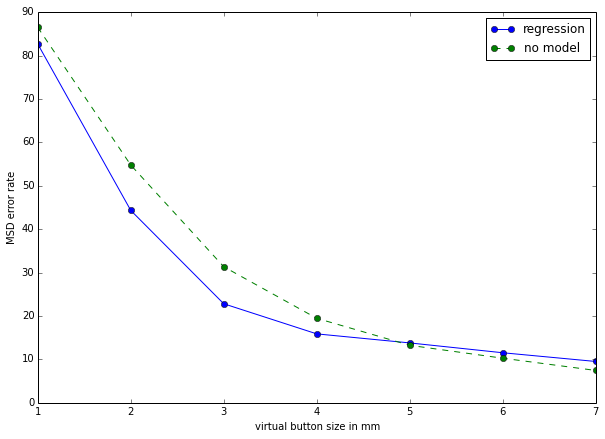

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

before = np.mean(error_typed, 0)
after = np.mean(error_pred, 0)

fig = plt.figure(figsize=(10, 7))

plt.errorbar(range(1,8), after, marker="o", label = "regression")
plt.errorbar(range(1,8), before, linestyle="--", marker="o", label="no model")

plt.legend(loc='best')
plt.xlabel('virtual button size in mm')
plt.ylabel('MSD error rate')
plt.show()